In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

**Lectura de archivo**


In [4]:
data = pd.read_csv("./weblog.csv");

**Limpieza de datos**

**Limpieza de IPS**

Para el funcionamiento correcto del algoritmo, es necesario realizar una limpieza a nuestro conjunto de datos para tenerlos estandarizados, en los log de servidores, se pueden mostrar errores como se puede apreciar en la siguiente celda de codigo.


In [5]:
data[~data.IP.str.contains('[0-9]*\.')]

,IP,Time,URL,Staus
1773,chmod:,cannot,'a.out':,No
1774,chmod:,cannot,'error.txt':,No
1775,rm:,cannot,'*.o':,No
1776,rm:,cannot,'a.out':,No
1782,chmod:,cannot,'error.txt':,No
...,...,...,...,...
15896,rm:,cannot,'*.o':,No
15897,rm:,cannot,'a.out':,No
15900,chmod:,cannot,'a.out':,No
15901,chmod:,cannot,'error.txt':,No


Estos errores no son utiles para nuestros analisis, ya que son errores del sistema operativo del servidor, por lo que debemos eliminarlos, para ello nos quedaremos con las entradas que solo contengan el patron de una ip.

In [6]:
data = data[data.IP.str.contains('[0-9]*\.')]
data.head()

,IP,Time,URL,Staus
0,10.128.2.1,[29/Nov/2017:06:58:55,GET /login.php HTTP/1.1,200
1,10.128.2.1,[29/Nov/2017:06:59:02,POST /process.php HTTP/1.1,302
2,10.128.2.1,[29/Nov/2017:06:59:03,GET /home.php HTTP/1.1,200
3,10.131.2.1,[29/Nov/2017:06:59:04,GET /js/vendor/moment.min.js HTTP/1.1,200
4,10.130.2.1,[29/Nov/2017:06:59:06,GET /bootstrap-3.3.7/js/bootstrap.js HTTP/1.1,200


**Limpeiza de tiempos**

En estos archivos, el servidor entrega una cadena de texto estructurada de la siguiente forma:
[DD/MMM/YYYY:HH:MM:SS]

Esto nos da un indicio que maneja un formato datetime, por lo que para facilidad de uso, los transformaremos en objetos datetime.

Para ello, eliminaremos los corchetes y el primer ":" de la cadena de texto y transformaremos las cadenas en objetos datetime.

In [7]:
data['Time'] = data['Time'].str.strip("[")
data['Time'] = data['Time'].str.replace(":",' ',1)
data = data[data.Time.str.contains('[0-9]{2}/[a-zA-Z]{3}/[0-9]{4}')]
data['Time']=pd.to_datetime(data['Time'])
data.head()

,IP,Time,URL,Staus
0,10.128.2.1,2017-11-29 06:58:55,GET /login.php HTTP/1.1,200
1,10.128.2.1,2017-11-29 06:59:02,POST /process.php HTTP/1.1,302
2,10.128.2.1,2017-11-29 06:59:03,GET /home.php HTTP/1.1,200
3,10.131.2.1,2017-11-29 06:59:04,GET /js/vendor/moment.min.js HTTP/1.1,200
4,10.130.2.1,2017-11-29 06:59:06,GET /bootstrap-3.3.7/js/bootstrap.js HTTP/1.1,200


**Limpieza de URLs**

Como hemos hablado, los log de servidores incluyen la respuesta a todas las peticiones que se le hacen al servidor, esto incluye archivos visuales, auxiliares y de estilos, para el analisis de uso web, no son relevantes por lo que los eliminaremos del dataset.

In [8]:
exts = ['gif','jpeg', 'GIF', 'JPEG', 'jpg', 'JPG', 'map','js','css','woff']
data['pages'] = (lambda db: db['URL'].map(lambda url: url.split()[1].split('?')[0].replace("/", "")))(data)

for ext in exts:
    data = data[~data.URL.str.contains(ext)]

data.head()

,IP,Time,URL,Staus,pages
0,10.128.2.1,2017-11-29 06:58:55,GET /login.php HTTP/1.1,200,login.php
1,10.128.2.1,2017-11-29 06:59:02,POST /process.php HTTP/1.1,302,process.php
2,10.128.2.1,2017-11-29 06:59:03,GET /home.php HTTP/1.1,200,home.php
5,10.130.2.1,2017-11-29 06:59:19,GET /profile.php?user=bala HTTP/1.1,200,profile.php
8,10.131.2.1,2017-11-29 06:59:30,GET /edit.php?name=bala HTTP/1.1,200,edit.php


**get_sessions()**

Esta funcion se encarga de lo siguiente:

* Obtener los usuarios
* Obtener las sesiones por cada usuario

Los usuarios, por facilidad se trabajaran con las ips unicas del data set.

Las sesiones por su lado, estaran definidas por un tiempo entre peticion y peticion de 30 minutos el cual es considerado un estandar, por lo tanto podemos determinar las sesiones de forma sencilla.


In [9]:
def get_sessions(usr,data):
    usr_data = data[data.IP.str.contains(u)]
    sesions = []
    sesion = []
    for i,value in usr_data.iterrows():
        try:
            last = sesion[-1]
            diference = value.Time - last.Time
            if diference.total_seconds()/60 <=30:
                sesion.append(value)
            else:
                sesions.append(sesion)
                sesion = []
        except IndexError:
            sesion.append(value)
    return sesions

**Obtencion de sesiones**

In [10]:
pages = { p:i for i, p in enumerate(data.pages.unique()) }
u_s = {}
usrs = data.IP.unique()
for u in usrs:
    u_s[u] = get_sessions(u,data)
u_s.keys()

dict_keys(['10.128.2.1', '10.130.2.1', '10.131.2.1', '10.129.2.1', '10.131.0.1'])

**Obtencion de Paginas Unicas Y construccion de matriz Usuario/Pagina**

Con la informacion anterior, podemos obtener la matriz de usuario pagina, en donde recorremos la lista de sesiones y agregamos un punto a cada una de las visitas que se realizaron a cierta pagina


In [11]:
# UP = [W(ui, pj )]m×n,
W = []
for usr, sessions in u_s.items():
    for session in sessions:
        sessionlist = [0]*len(pages)
        for page in session:
            sessionlist[pages[page['pages']]] += 1
        W.append(sessionlist)
        
W_u_p = np.array(W)
print(W_u_p.shape)
print(W_u_p)

(975, 39)
[[1 1 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [1 1 9 ... 0 0 0]
 ...
 [4 0 0 ... 0 0 0]
 [4 1 3 ... 0 0 0]
 [3 2 1 ... 0 0 0]]


# Esperanza

Esta funcion se encarga de obtener la esperanza de un valor dado con respecto a la probabilidad general

In [12]:
def Expectation(pz,puz,ppz,i,j,k):
    #k primes
    kprimes = range(len(pz))
    # (P(zk )P(ui|zk )P(pj|zk )) / (sumatoria(P(zprimak)P(ui|zprimak)P(pj|zprimak)))
    return (pz[k]*puz[i,k]*ppz[j,k])/((pz[kprimes]*puz[i,kprimes]*ppz[j,kprimes]).sum())

# Maximización

In [13]:
def Maximization(W_u_p,nusrs,npags,ntasks, PZUP):
    # resultados maximizados para pz, puz, ppz 
    # Pz
    # vector tamaño ntasks
    pz= []
    # Puz
    # matrix tamaño nusers x ntasks
    puz= []
    # Ppz
    # matrix tamaño npages x ntasks
    ppz=[]
    for k in range(ntasks):
        pz.append(ProbZ(W_u_p,PZUP[:,:,k]))
        
    for i in range(nusrs):
        puz_list = []
        for k in range(ntasks):
            puz_list.append(ProbUZ(W_u_p,i,PZUP[:,:,k]))
        puz.append(puz_list)
        
    for j in range(npags):
        ppz_list = []
        for k in range(ntasks):
            ppz_list.append(ProbPZ(W_u_p,j,PZUP[:,:,k]))
        ppz.append(ppz_list)
    
    return np.array([np.array(pz) , np.array(puz), np.array(ppz) ])

# Probabilidades
Esta funcion se encarga de obtener las probabilidades para cada uno de los valores que se les indique.

In [14]:
def ProbZ(W_u_p,PZUP):
    num = 0
    dem = 0
    for j in range(W_u_p.shape[1]):
        num   = num + (W_u_p[:,j]*PZUP[:,j]).sum()
        dem = dem + W_u_p[:,j].sum()
    return num/dem

def ProbUZ(W_u_p,i,PZUP):
    num   = (W_u_p[i,:]*PZUP[i,:]).sum()
    #i primes
    iprimes = range( W_u_p.shape[0])
    dem = (W_u_p[iprimes]*PZUP[iprimes]).sum()
    return num/dem

def ProbPZ(W_u_p,j,PZUP):
    num   = (W_u_p[:,j]*PZUP[:,j]).sum()
    #j primes 
    jprimes = range( W_u_p.shape[1])
    dem = (W_u_p[jprimes]*PZUP[jprimes]).sum()
    return num/dem

# PSLA

In [15]:
# Numero de iteraciones
itera = 3
# Numero de tareas
ntasks= 3
# Numero de usuarios
# Numero de paginas
nusrs, npags = W_u_p.shape
print(ntasks, nusrs, npags)
#INICIALIZAR matrix random entre 0 y 1, cuya suma sea igual a 1
pz_init = np.random.dirichlet(np.ones(ntasks))
puz_init = np.random.dirichlet(np.ones(ntasks), nusrs)
ppz_init = np.random.dirichlet(np.ones(ntasks), npags)
maximization = np.array([pz_init, puz_init, ppz_init])

#Inicia 
count = 0
while count <  itera:
    count = count + 1
    #Esperanza, para todos los valores nxmxz de la matriz inicializada
    exp = []
    for i in range(nusrs):
        exp_ls1 = []
        for j in range(npags):
            exp_ls2 = []
            for k in range(ntasks):
                exp_ls2.append(Expectation(maximization[0], maximization[1], maximization[2], i, j, k))
            exp_ls1.append(exp_ls2)
        exp.append(exp_ls1)
    expectative_matrix = np.array(exp)
    # Max()
    maximization = Maximization(W_u_p, nusrs, npags, ntasks, expectative_matrix)

3 975 39


<ipython-input-15-2754b9ed72dd>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  maximization = np.array([pz_init, puz_init, ppz_init])
<ipython-input-13-dfb112b6e8d2>:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([np.array(pz) , np.array(puz), np.array(ppz) ])


In [16]:
# 3 dimension matrix
expectative_matrix

array([[[5.49310988e-01, 3.60252320e-06, 4.50685409e-01],
        [6.45336642e-01, 1.70027410e-05, 3.54646355e-01],
        [1.54859856e-01, 1.71593729e-05, 8.45122985e-01],
        ...,
        [5.04578325e-01, 7.38565110e-06, 4.95414289e-01],
        [7.77636951e-01, 5.65151060e-05, 2.22306534e-01],
        [9.51770786e-01, 2.51481970e-05, 4.82040662e-02]],

       [[1.32995781e-01, 3.56550264e-03, 8.63438716e-01],
        [1.83274906e-01, 1.97392214e-02, 7.96985873e-01],
        [2.24031287e-02, 1.01476536e-02, 9.67449218e-01],
        ...,
        [1.13262186e-01, 6.77703193e-03, 8.79960783e-01],
        [2.80962312e-01, 8.34699442e-02, 6.35567744e-01],
        [6.62788828e-01, 7.15886315e-02, 2.65622540e-01]],

       [[3.28124510e-01, 1.50401181e-03, 6.70371478e-01],
        [4.18958667e-01, 7.71485677e-03, 5.73326477e-01],
        [6.81806421e-02, 5.28016779e-03, 9.26539190e-01],
        ...,
        [2.89424467e-01, 2.96087118e-03, 7.07614662e-01],
        [5.67325080e-01, 2.88

# PZ, PUZ, PPZ

In [17]:
#pz
print("PZ = ", maximization[0].shape)
print(maximization[0])
print("suma =", maximization[0].sum())
#puz
print("P U|Z = ", maximization[1].shape)
print(maximization[1])

#ppz
print("P P|Z = ", maximization[2].shape)
print(maximization[2])

PZ =  (3,)
[0.25882161 0.01117412 0.73000427]
suma = 1.0000000000000004
P U|Z =  (975, 3)
[[5.31015875e-04 3.44195023e-07 2.30256004e-04]
 [9.96042555e-05 4.60079663e-04 6.55196312e-04]
 [1.72921234e-03 1.19157944e-03 2.57741646e-03]
 ...
 [7.67773796e-04 3.05623163e-06 4.25293712e-04]
 [3.47952555e-05 1.24089191e-04 1.65989170e-03]
 [1.97172691e-03 9.22422023e-03 8.33861250e-04]]
P P|Z =  (39, 3)
[[5.27469217e+00 1.69645141e-01 5.56065237e+00]
 [7.02843449e-01 1.53265415e-01 3.99274021e-01]
 [7.92197136e-01 5.56544810e-01 6.27398576e+00]
 [4.15540665e-02 1.22462407e+00 2.66250393e-01]
 [2.23097589e-03 1.65380557e-02 3.46731549e-02]
 [9.38084933e-02 1.12078773e-02 6.07129354e-02]
 [9.96351941e-01 1.12703328e+00 8.29236658e-01]
 [5.45337050e-01 3.33543104e-01 1.10170521e+00]
 [8.49068234e-02 5.90481272e-03 1.39207176e-01]
 [1.02813326e+00 3.72281753e-01 2.06555982e-01]
 [8.81692311e-02 1.25929229e-02 1.87032531e-01]
 [5.54189558e-01 1.66010818e-01 3.31691567e-01]
 [1.57165529e-01 7.9890

In [18]:
expectative_matrix[0,0,:].sum()

1.0

# AGRUPAMIENTO

In [19]:
def info_cluster(labels_):
    labels= pd.DataFrame()
    labels["grups"]= labels_
    labels
    quantity=  pd.DataFrame()
    quantity["quantity"]= labels.groupby("grups").size()
    return quantity

In [20]:
def Cluster_K_Means(expectative_matrix, n_tasks, n_clusters):
    #matriz_esperanza[:,:,0].shape
    matrix_EM= expectative_matrix[:,:,n_tasks]
    matrix_EM_transpose= np.transpose(expectative_matrix[:,:,n_tasks])
    #Sesiones
    sessions = np.dot(matrix_EM, matrix_EM_transpose )
    #Sesiones
    #Pagina
    pages = np.dot(matrix_EM_transpose, matrix_EM )
    #Pagina
    #print paginas.shape
    #DISTANCIA
    sess = 1.0/(1+(0.5*sessions))
    pags = 1.0/(1+(0.5*pages))
    clustering_sessions = KMeans( n_clusters= n_clusters).fit(sessions)
    clustering_pages = KMeans(n_clusters= n_clusters).fit(pages)
    return clustering_sessions, clustering_pages, sess, pags



In [21]:
sessions, pages, matrix_sessions, matrix_pages = Cluster_K_Means(expectative_matrix, 0,3)

In [22]:
quantity_sessions = info_cluster(sessions.labels_)
print("Info sessions cluster")
print(quantity_sessions)
quantity_pages = info_cluster(pages.labels_)
print("Info sessions pages")
print(quantity_pages)

Info sessions cluster
       quantity
grups          
0           368
1           215
2           392
Info sessions pages
       quantity
grups          
0            20
1             5
2            14


<ipython-input-23-085dc24090ad>:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bx-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(K, Sum_of_squared_distances, 'bx-' , color="yellow")


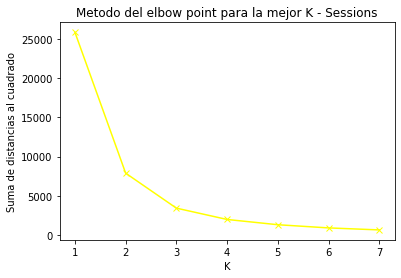

In [23]:
# Sessions
# CALCULANDO CON INERTIA
Sum_of_squared_distances = []
K = range(1,8)
for k in K:
    km = KMeans(n_clusters=k).fit(matrix_sessions)
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-' , color="yellow")
plt.xlabel('K')
plt.ylabel('Suma de distancias al cuadrado')
plt.title('Metodo del elbow point para la mejor K - Sessions')
plt.show()

<ipython-input-24-7c2bf55fe5bc>:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bx-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(K, Sum_of_squared_distances, 'bx-' , color="green")


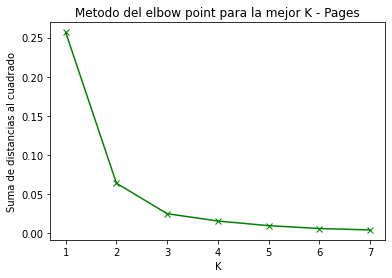

In [24]:
# PAGES
# CALCULANDO CON INERTIA
Sum_of_squared_distances = []
K = range(1,8)
for k in K:
    km = KMeans(n_clusters=k).fit(matrix_pages)
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-' , color="green")
plt.xlabel('K')
plt.ylabel('Suma de distancias al cuadrado')
plt.title('Metodo del elbow point para la mejor K - Pages')
plt.show()

160300117 - Oregon Baltazar Jorge David

160300153 - Vazquez Pompa Noe